In [47]:
import os, sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
bigdama_path = "/home/andres/CAiN_repos/OutlierDenStream-BigDama18/"
sys.path.append(bigdama_path)

from readGroundTruth import groundTruth

In [49]:
def normalize_matrix(df):
    return (df - df.mean())/df.std()

configuration = json.load(open('configuration.json'))
print(configuration['featureModel'])

# Iterate on all the datasets chosen in the configuration list
for dataset in configuration['dataset']['list']:
    
    # read the ground truth file
    truth = groundTruth(bigdama_path + 'GrounTruth/'+dataset+'.txt', fileType='csv')
    
    # Iterate on all the nodes chosen in the configuration file
    for node in configuration['nodes']:

        # Read node dataset
        print('Dataset {} - Node: {} loading ...'.format(dataset,node))
        df = pd.read_csv(bigdama_path+configuration['dataset']['path']+node+dataset+'.csv', low_memory = False)\
                        .dropna()\
                        .drop('Unnamed: 0', axis=1)
        print('Done.')
        
        times = pd.DataFrame(columns=['time'])
        times['time'] = df['time'].astype('int')
        df = df.drop(['time'], axis=1)

        # Select the chosen features in the configuration file
        # By default the dataset contains all the features
        # If ControlPlane is chosen: only the CP features are extracted from the dataset
        # If DataPlane is chosen: the CP features are discarded, obtaining a dataset with only DataPlane
        # If CompleteFeatures is chosen: pass
        if configuration['featureModel'] == 'ControlPlane':
            df = df[configuration['featureList']]
        elif configuration['featureModel'] == 'DataPlane':
            df = df.drop(configuration['featureList'], axis=1)
        elif configuration['featureModel'] == 'CompleteFeatures':
            pass
        else:
            sys.exit('Something wrong in configuration feature model')

        # Dataset normalization
        df = df.loc[:,df.std()!=0]
        dfNormalized = normalize_matrix(df).dropna(axis=1)

DataPlane
Dataset bgpclear_first - Node: spine4 loading ...
Done.


In [50]:
dfNormalized.describe()
dfNormalized.head()

,HundredGigE0/0/0/0input-data-rate,HundredGigE0/0/0/0input-load,HundredGigE0/0/0/0input-packet-rate,HundredGigE0/0/0/0output-data-rate,HundredGigE0/0/0/0output-load,HundredGigE0/0/0/0output-packet-rate,HundredGigE0/0/0/1input-data-rate,HundredGigE0/0/0/1input-load,HundredGigE0/0/0/1input-packet-rate,HundredGigE0/0/0/1output-data-rate,...,HundredGigE0/0/0/7packets-received,HundredGigE0/0/0/7packets-sent,HundredGigE0/0/0/8bytes-received,HundredGigE0/0/0/8bytes-sent,HundredGigE0/0/0/8packets-received,HundredGigE0/0/0/8packets-sent,HundredGigE0/0/0/9bytes-received,HundredGigE0/0/0/9bytes-sent,HundredGigE0/0/0/9packets-received,HundredGigE0/0/0/9packets-sent
0,0.006850,0.025425,-0.002027,-0.124960,-0.124742,-0.122099,-0.173828,-0.144322,-0.172667,-0.086790,...,-1.649496,-1.586319,-1.642843,-1.639723,-1.644851,-1.639586,-1.626859,-1.628776,-1.629567,-1.629513
1,0.009240,0.025425,0.000679,-0.119348,-0.124742,-0.117091,-0.153972,-0.144322,-0.153571,-0.106251,...,-1.643284,-1.581376,-1.636854,-1.634034,-1.638840,-1.633874,-1.621143,-1.622728,-1.623842,-1.623471
2,0.006352,0.025425,-0.001989,-0.113579,-0.124742,-0.111195,-0.152070,-0.144322,-0.151274,-0.111889,...,-1.639479,-1.578464,-1.633234,-1.630137,-1.635203,-1.629995,-1.617606,-1.619062,-1.620282,-1.619819
3,0.014411,0.025425,0.005656,-0.124613,-0.124742,-0.121648,-0.147763,-0.144322,-0.146147,-0.114135,...,-1.634829,-1.574302,-1.628212,-1.625161,-1.630180,-1.625025,-1.613115,-1.614221,-1.615760,-1.614989
4,0.015780,0.025425,0.006100,-0.137729,-0.124742,-0.134401,-0.134673,-0.144322,-0.133835,-0.106197,...,-1.629772,-1.570042,-1.623215,-1.620217,-1.625167,-1.620068,-1.608429,-1.608983,-1.611041,-1.609799


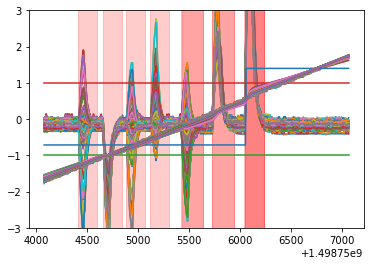

In [51]:
fig, ax = plt.subplots()
#ax.plot(times, dfNormalized['active-routes-count'], 'b')
#ax.plot(times, dfNormalized['deleted-routes-count'], 'g')
#ax.plot(times, dfNormalized['paths-count'], 'r')
#ax.plot(times, dfNormalized['protocol-route-memory'], 'y')
ax.plot(times, dfNormalized)
#ax.axis([0, 700, 900, 1500])
ax.set_ylim([-3, 3])
for anomaly in truth.events:
    ax.axvspan(anomaly['startTime'], anomaly['endTime'], alpha=0.2, color='red')

In [52]:
# Create anomaly data
times['anomaly'] = 0 # add new column

# flag entries within anomaly ranges
for anomaly in truth.events:
    mask = times['time'].between(anomaly['startTime'], anomaly['endTime'])
    times['anomaly'] = times['anomaly'].mask(mask, 1)

In [53]:
dfNormalized[0:].to_csv('bgpclear_first_spline4_DP.emb', index=False, header=False, na_rep=0, sep='\t')

In [54]:
times[0:].to_csv('bgpclear_first_spline4_DP.lbl', index=False, header=True, na_rep=0, sep='\t')

In [57]:
len(times[times['anomaly'] == 0])

356